In [1]:
import numpy as np


def offdiag_l1_norm(M):
    """Compute the L1 norm of off-diagonal entries."""
    return np.sum(np.abs(M - np.diag(np.diag(M))))

def soft_threshold_offdiag(M, lam):
    """
    Soft-threshold only the off-diagonal entries of M by lam.
    Diagonal entries are unchanged.
    """
    diag_part = np.diag(np.diag(M))
    offdiag_part = M - diag_part
    offdiag_thresh = np.sign(offdiag_part) * np.maximum(np.abs(offdiag_part) - lam, 0.0)
    return diag_part + offdiag_thresh

def negative_loglike_grad(Theta, S, n):
    """
    Gradient of the negative log-likelihood term:
      n * [ - log det(Theta) + trace(S * Theta) ]
    w.r.t. Theta is:
      n * [ - inv(Theta) + S ]
    """
    inv_Theta = np.linalg.inv(Theta)
    return n * (-inv_Theta + S)

def psi_l1(X):
    """Elementwise L1 norm."""
    return np.sum(np.abs(X))

def psi_group_l2(X):
    """Group-lasso norm: sum of column L2 norms."""
    val = 0.0
    for j in range(X.shape[1]):
        col = X[:, j]
        val += np.linalg.norm(col)
    return val

def psi_laplacian(X):
    """
    'Smooth' penalty = 0.5 * ||X||^2_F.
    Factor 0.5 is convenient for its gradient.
    """
    return 0.5 * np.sum(X * X)

def psi_grad(X, psi_type):
    """
    Returns the gradient (or subgradient) of psi(X) for
    the specified psi_type in {"l1", "group_l2", "laplacian"}.
    """
    if psi_type == "l1":
        # subgradient for elementwise L1 = sign(X)
        return np.sign(X)
    elif psi_type == "group_l2":
        # each column is a 'group'
        G = np.zeros_like(X)
        for j in range(X.shape[1]):
            col = X[:, j]
            norm_col = np.linalg.norm(col)
            if norm_col > 1e-12:
                G[:, j] = col / norm_col
        return G
    elif psi_type == "laplacian":
        # derivative of 0.5 * ||X||^2_F is X
        return X
    else:
        raise NotImplementedError(f"Unknown psi_type={psi_type}.")


# -------------------------------------------------------------------
# Main solver function
# -------------------------------------------------------------------
def solve_tvgl(
    S_list,
    n_list,
    lam=0.1,
    beta=0.1,
    psi_type="l1",
    step_size=1e-3,
    max_iter=50,
    tol=1e-4
):
    """
    Solves the Time-Varying Graphical Lasso problem via proximal gradient:
      min_{Theta_1,...,Theta_T}
        sum_{i=1..T} [ -n_i ( log det(Theta_i) - trace(S_i * Theta_i) )
                       + lam * ||Theta_i||_{od,1} ]
        + beta * sum_{i=2..T} psi( Theta_i - Theta_{i-1} )
    
    Parameters
    ----------
    S_list : list of np.ndarray
        Empirical covariances, one for each time i=1..T.
    n_list : list of int
        Sample sizes for each time i=1..T.
    lam : float
        Penalty weight for L1 off-diagonal terms.
    beta : float
        Penalty weight for temporal difference.
    psi_type : str
        Type of temporal penalty: {"l1", "group_l2", "laplacian"}.
    step_size : float
        Step size for gradient descent.
    max_iter : int
        Max number of iterations.
    tol : float
        Stopping threshold for Frobenius norm difference across Theta updates.
    
    Returns
    -------
    Thetas : list of np.ndarray
        The estimated precision matrices (Theta_i for i=1..T).
    """

    T = len(S_list)
    p = S_list[0].shape[0]
    Thetas = [np.eye(p) for _ in range(T)]  # initialize to identity

    for iteration in range(max_iter):
        old_Thetas = [Th.copy() for Th in Thetas]

        # Compute gradient for each Theta_i
        grad_list = []
        for i in range(T):
            g = negative_loglike_grad(Thetas[i], S_list[i], n_list[i])

            # Add derivative from beta * psi(Theta_i - Theta_{i-1})
            if i > 0:
                diff_fwd = Thetas[i] - Thetas[i-1]
                g += beta * psi_grad(diff_fwd, psi_type)

            # Subtract derivative from beta * psi(Theta_{i+1} - Theta_i)
            if i < T - 1:
                diff_bwd = Thetas[i+1] - Thetas[i]
                g -= beta * psi_grad(diff_bwd, psi_type)

            grad_list.append(g)

        # Gradient step + prox for each Theta_i
        for i in range(T):
            Theta_new = Thetas[i] - step_size * grad_list[i]
            # off-diagonal soft thresholding
            Theta_new = soft_threshold_offdiag(Theta_new, lam * step_size)
            # symmetrize
            Theta_new = 0.5 * (Theta_new + Theta_new.T)
            # small shift on diagonal to help positivity
            Theta_new += 1e-7 * np.eye(p)
            Thetas[i] = Theta_new

        # Check convergence
        max_diff = 0.0
        for i in range(T):
            diff_norm = np.linalg.norm(Thetas[i] - old_Thetas[i], ord='fro')
            if diff_norm > max_diff:
                max_diff = diff_norm

        if max_diff < tol:
            print(f"Converged at iteration {iteration+1}, update norm={max_diff:.2e}")
            break

    return Thetas


# -------------------------------------------------------------------

def random_spd_matrix(p, seed=None):
    """Generate a random (p x p) SPD matrix."""
    if seed is not None:
        np.random.seed(seed)
    A = np.random.randn(p, p)
    M = A.T @ A
    # shift diagonal to ensure it's well-conditioned
    M += p * np.eye(p)
    return M

T = 5
p = 3
S_list = []
n_list = []
for t in range(T):
    S_list.append(random_spd_matrix(p, seed=42 + t))
    n_list.append(50)  # say 50 samples each time

# Solve
Thetas_est = solve_tvgl(
    S_list, n_list,
    lam=0.1,
    beta=0.1,
    psi_type="l1",
    step_size=1e-3,
    max_iter=100,
    tol=1e-5
)

# Print results
print("Final Thetas:")
for idx, Theta in enumerate(Thetas_est, 1):
    print(f"\nTheta_{idx}:\n{Theta}")


Final Thetas:

Theta_1:
[[ 0.300403    0.00634614 -0.00685571]
 [ 0.00634614  0.28667742  0.01869699]
 [-0.00685571  0.01869699  0.28388701]]

Theta_2:
[[ -0.22411893  -4.64870646  -2.45480011]
 [ -4.64870646 -42.20445419 -22.00082984]
 [ -2.45480011 -22.00082984 -11.11115998]]

Theta_3:
[[-20.51419899 -20.3625417  -22.04752399]
 [-20.3625417  -19.91205074 -21.91220962]
 [-22.04752399 -21.91220962 -23.39096895]]

Theta_4:
[[  0.08176576  -1.53503002  -3.29058524]
 [ -1.53503002  -9.63560283 -20.86904685]
 [ -3.29058524 -20.86904685 -43.8262947 ]]

Theta_5:
[[ 0.2585821  -0.01441812 -0.03986007]
 [-0.01441812  0.2116511  -0.05405604]
 [-0.03986007 -0.05405604  0.29017959]]


In [2]:
from data_generation import *


ModuleNotFoundError: No module named 'data_generation'

In [4]:
import os
print(os.getcwd(
))

/Users/mahdibenayed/Desktop/TVGL_python/TVGL-in-python/Examples


In [5]:
os.chdir("/Users/mahdibenayed/Desktop/TVGL_python/TVGL-in-python")

In [6]:
from data_generation import *

In [39]:
N = 2000  
d = 6      
T = 20 
t_shift = 10
delta = 0.2

data, covariances = generate_time_varying_gaussian_data_with_perturbation(N, d, T, t_shift, delta)

/Users/mahdibenayed/Desktop/TVGL_python/TVGL-in-python/data_generation.py:118: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, covariance, samples_per_period)


In [40]:
S_list=covariances

In [41]:
len(S_list)

20

In [42]:
n_list=[10 for i in range(len(S_list))]

In [43]:


Thetas_est = solve_tvgl(
    S_list, n_list,
    lam=0.1,
    beta=0.1,
    psi_type="laplacian",
    step_size=1e-3,
    max_iter=100,
    tol=1e-5
)

# Print results
print("Final Thetas:")
for idx, Theta in enumerate(Thetas_est, 1):
    print(f"\nTheta_{idx}:\n{Theta}")


Final Thetas:

Theta_1:
[[ 1.07153191 -0.17322766 -0.23320325 -0.07832787  0.05682869  0.32451458]
 [-0.17322766  1.08250591 -0.13682457 -0.00981421  0.1692984  -0.26110758]
 [-0.23320325 -0.13682457  1.1483819   0.00261428  0.47991617 -0.06928064]
 [-0.07832787 -0.00981421  0.00261428  1.03486446  0.12895105  0.27346356]
 [ 0.05682869  0.1692984   0.47991617  0.12895105  1.15808623  0.23707061]
 [ 0.32451458 -0.26110758 -0.06928064  0.27346356  0.23707061  1.11245921]]

Theta_2:
[[ 1.07153191 -0.17322766 -0.23320325 -0.07832787  0.05682869  0.32451458]
 [-0.17322766  1.08250591 -0.13682457 -0.00981421  0.1692984  -0.26110758]
 [-0.23320325 -0.13682457  1.1483819   0.00261428  0.47991617 -0.06928064]
 [-0.07832787 -0.00981421  0.00261428  1.03486446  0.12895105  0.27346356]
 [ 0.05682869  0.1692984   0.47991617  0.12895105  1.15808623  0.23707061]
 [ 0.32451458 -0.26110758 -0.06928064  0.27346356  0.23707061  1.11245921]]

Theta_3:
[[ 1.07153191 -0.17322766 -0.23320325 -0.07832787  0.0

In [44]:
len(Thetas_est)

20

In [45]:
divergences = [np.linalg.norm(Thetas_est[i] - Thetas_est[i-1], ord='fro') for i in range(1, len(Thetas_est))]


In [46]:
divergences

[0.0,
 0.0,
 0.0,
 7.351626287044711e-17,
 3.343378594568868e-14,
 2.1483320545851665e-11,
 1.1477408058025799e-08,
 4.960704293714974e-06,
 0.0016754356945115243,
 0.41532093217670063,
 0.41532093217670063,
 0.0016754356945115243,
 4.960704293714974e-06,
 1.1477408058025799e-08,
 2.1483320545851665e-11,
 3.343378594568868e-14,
 7.351626287044711e-17,
 0.0,
 0.0]

In [47]:
len(divergences)

19

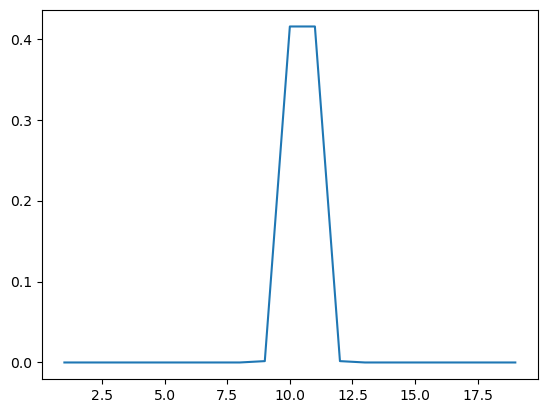

In [48]:
import matplotlib.pyplot as plt
x=[i for i in range(1,20)]
plt.plot(x,divergences)